In [26]:
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
#import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib as mpl
from scipy import stats
from utils import analyze_order, find_best_model, ljung_box_test, analyze_cointegration

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import statsmodels.api as sm
import warnings

ImportError: cannot import name 'analyze_cointegration' from 'utils' (c:\Users\loren\OneDrive\Desktop\PhD\Progetto\python\src\utils.py)

In [3]:
os.chdir('C:\\Users\\loren\\OneDrive\\Desktop\\PhD\\Progetto\\python\\')
path = 'data'

In [4]:
df = pd.read_csv(os.path.join(path, "ue27_df.csv"))

df['Time'] = pd.to_datetime(df['Time'], format="%Y-%m-%d")

df['Time'] = df['Time'].dt.strftime('%Y-%m')

#df.sort_values(by='Time', ascending=False)
#
#df.reset_index(drop=True)
#
#df = df.drop(df.columns[0], axis=1)

In [5]:
#df.set_index('Time', inplace=True)

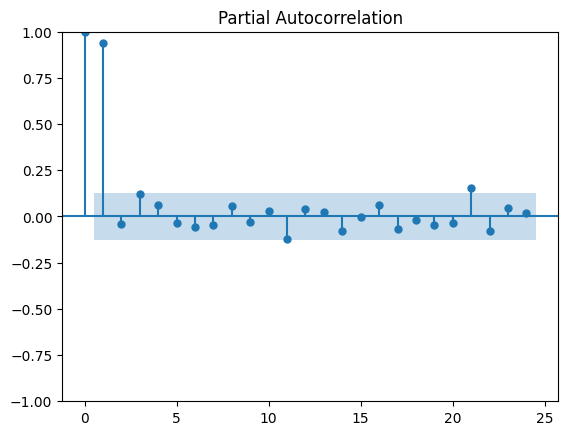

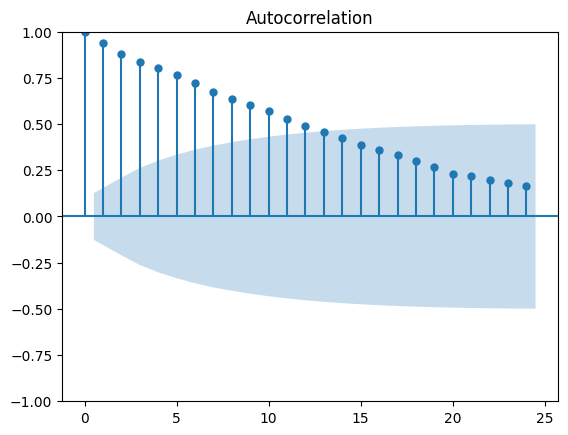

In [6]:
pacf = plot_pacf(df.IP, lags=24)

acf = plot_acf(df.IP, lags=24)

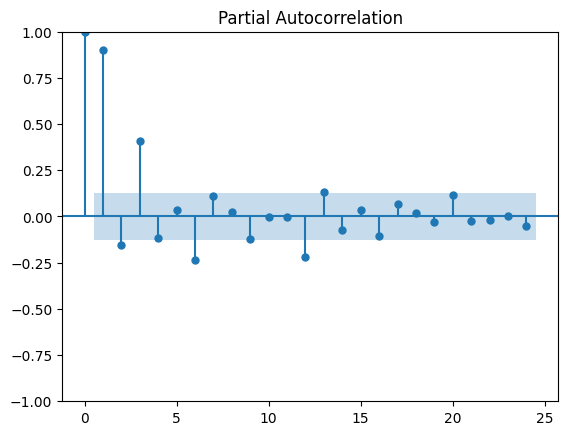

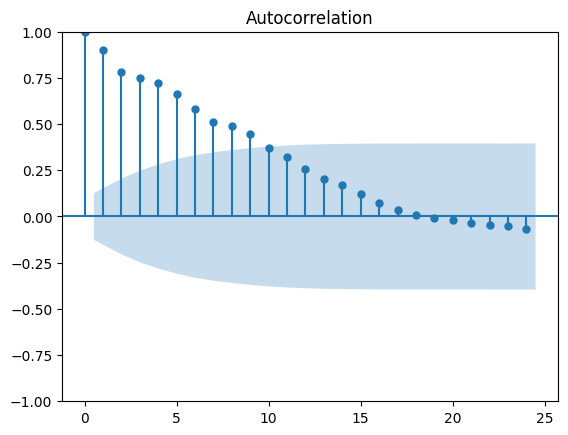

In [7]:
pacf = plot_pacf(df.GAS_PRICE, lags=24)

acf = plot_acf(df.GAS_PRICE, lags=24)

In [8]:
adf_ip = adfuller(df.IP)
print('value',adf_ip[0])
print('p-value',adf_ip[1])

value -1.906419814446655
p-value 0.32904708060949134


In [9]:
adf_gp = adfuller(df.GAS_PRICE)
print('value', adf_gp[0])
print('p-value', adf_gp[1])

value -3.0384825158221407
p-value 0.03145357331650854


In [10]:
df['IP_diffed'] = df['IP'] - df['IP_t1'] 

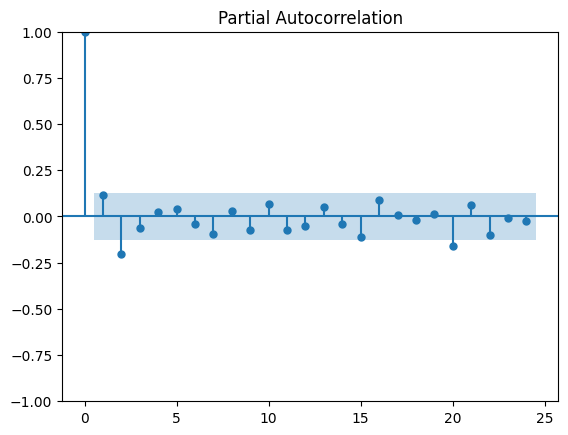

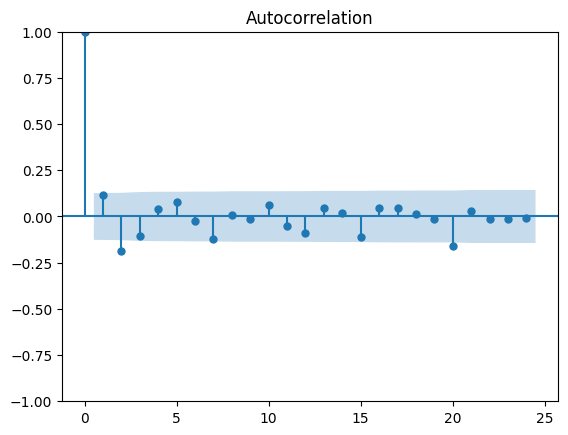

In [11]:
pacf = plot_pacf(df.IP_diffed, lags=24)

acf = plot_acf(df.IP_diffed, lags=24)

In [12]:
orders = [(p, 1, q) for p in range(3) for q in range(3)]

# Dictionary to store order, summary, and residuals
order_results = {}
warning_orders = []  # List to track orders with the specific warning

# Fit models and store summaries
for order in orders:
    try:
        with warnings.catch_warnings(record=True) as w:
            # Filter specific warnings
            warnings.simplefilter("always")
            
            # Fit the ARIMA model
            model = ARIMA(df['IP'], order=order)
            model_fit = model.fit()
            
            # Store the summary and residuals in the dictionary
            order_results[order] = {
                "summary": model_fit.summary(),
                "residuals": model_fit.resid
            }
            
            # Check if the specific warning occurred
            for warning in w:
                if "Non-invertible starting MA parameters found" in str(warning.message):
                    warning_orders.append(order)
    
    except Exception as e:
        # Handle exceptions (e.g., if a model can't be fit)
        print(f"Failed to fit model for order {order}: {e}")

# Display orders that triggered the warning
print("Orders with non-invertible starting MA parameters warning:", warning_orders)

Orders with non-invertible starting MA parameters warning: []


In [13]:
best_model, best_rmse = find_best_model(order_results)

Best ARIMA order: (2, 1, 2) with RMSE: 6.294898295931248


Summary for ARIMA order (1, 1, 0):

                               SARIMAX Results                                
Dep. Variable:                     IP   No. Observations:                  240
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -527.845
Date:                Fri, 06 Dec 2024   AIC                           1059.690
Time:                        11:14:58   BIC                           1066.643
Sample:                             0   HQIC                          1062.492
                                - 240                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1207      0.015      8.038      0.000       0.091       0.150
sigma2         4.8509      0.125     38.749      0.000       4.606       5.096
Ljung-Box (L1) (

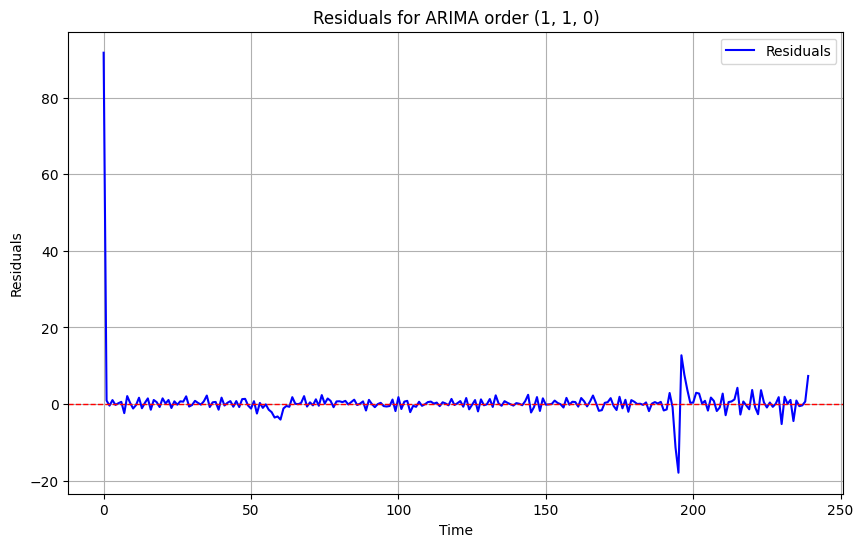

<Figure size 1000x600 with 0 Axes>

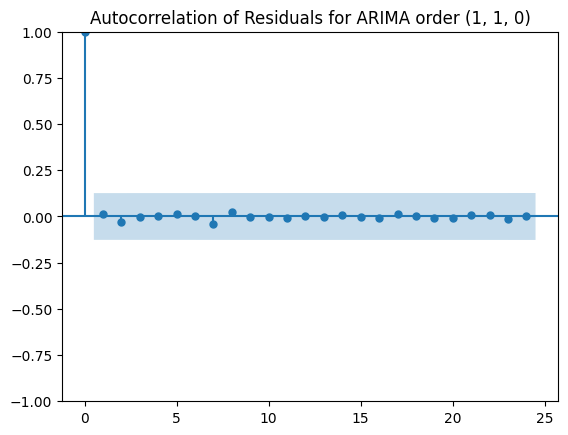

In [14]:
analyze_order((1, 1, 0), order_results)

In [ ]:
#residuals = order_results[(0, 1, 0)]['residuals']
#print(residuals.head(10))

In [16]:
ljung_box_test((0,1,0), order_results, lags=12)

Ljung-Box Test Results for ARIMA order (0, 1, 0):


Residuals show no significant autocorrelation (p-value >= 0.05).


,lb_stat,lb_pvalue
1,0.117903,0.731320
2,0.287906,0.865928
3,0.292642,0.961406
4,0.294979,0.990136
5,0.324546,0.997156
6,0.325126,0.999366
7,0.693076,0.998388
8,0.767039,0.999335
9,0.768103,0.999812
10,0.772061,0.999948


In [24]:
data = df[['IP','GAS_PRICE']]

analyze_cointegration(data)

{'Johansen': {'Trace Statistics': [28.986072019157554, 4.988073456858389],
  'Critical Values': [[13.4294, 15.4943, 19.9349], [2.7055, 3.8415, 6.6349]],
  'Rank': '>1'},
 'Engle-Granger': {'Score': np.float64(-2.3371349998993844),
  'P-Value': np.float64(0.35517645845692636)}}